In [1]:
import os
import time
import numpy as np
import pandas as pd
from radar.dataparsing.td_textdata_parser import read_columns
from scipy.fftpack import fft
from matplotlib import pyplot as plt

td_data = []

# Different Test Cases
# timeStampFolder = "2024-10-17_11-57-43.359" # Take-off (at least 4 drones)
# timeStampFolder = "2024-10-17_12-04-36.137" # Landing UAVs - for at least 2 UAVs
# timeStampFolder = "2024-10-17_15-59-35.092" # Up/Down Movement (for 5 UAVs)

# DJ Mini Tests - hovering overtop the radar tests, distances mentioned
# timeStampFolder = "2024-10-18_09-55-39.076 1.3m"
# timeStampFolder = "2024-10-18_09-59-12.941 5.0m"
timeStampFolder = "2024-10-18_10-02-03.580 15m"
# timeStampFolder = "2024-10-18_10-13-20.561 20m"
# timeStampFolder = "2024-10-18_10-10-43.904 29m"

directory_to_process = f"/data/radar/Oct17/{timeStampFolder}/TD"


# directory_to_process = f"output/2024-09-29_20-20-41/radar"

def process_data_from_folder(self):
        
        # List all files in the directory
        files = os.listdir(directory_to_process)
        
        # Filter the files based on the naming convention
        txt_files = [f for f in files if f.endswith('.txt')]
        
        # Sort the files if needed (optional)
        txt_files.sort()
        
        # Process each file one by one
        for file_name in txt_files:
            file_path = os.path.join(directory_to_process, file_name)
            new_fd_data = read_columns(file_path)
            td_data.append(new_fd_data.td_data)
        
            
process_data_from_folder(directory_to_process)
td_data = np.array(td_data)
I1_data = td_data[:, :, 0]  # Extract the I1 signal, which is the first column across all frames and range bins
Q1_data = td_data[:, :, 1]  # Extract the Q1 signal, which is the second column across all frames and range bins
I2_data = td_data[:, :, 2]  # Extract the I2 signal, which is the third column across all frames and range bins
Q2_data = td_data[:, :, 3]  # Extract the IQ2 signal, which is the fourth column across all frames and range bins
x1 = I1_data + 1j * Q1_data
x2 = I2_data + 1j * Q2_data

## Populate all the radar variables required:
TIME_STEP = 0.241
WAVELENGTH = 0.01233714
C = 299792458  # Speed of light (m/s)

f_0 = 24e9  # Center Frequency (Hz)
f_c = 24.500e9  # Center Frequency (Hz)
f_chirp = 4.14937759  # Chirp Sequence Frequency (Hz)
f_r = 750e6  # Ramp Frequency (Hz)
T_r = 0.241  # Duration of one cycle (s) - Chirp sequence
m_w = f_r / T_r  # Slope of the ramp (Hz/s)
n_r = I1_data.shape[0] # number of total chirps - assumes all have the same shape, which they should
n_s = I1_data.shape[1] # number of samples - assumes all have the same shape, which they should
T_M = T_r * n_r  # Total measurement time (s)
f_s = 1 / TIME_STEP

SINGLE_TO_PROCESS = I1_data

print(f"Num samples: {td_data.shape[0]}")

Num samples: 382


/tmp/ipykernel_1921/662107450.py:8: UserWarning: Input data is complex, switching to return_onesided=False
  f1, t1, Sxx1 = spectrogram(x1.flatten(), fs=Fs, nperseg=1024, noverlap=512)
/tmp/ipykernel_1921/662107450.py:11: UserWarning: Input data is complex, switching to return_onesided=False
  f2, t2, Sxx2 = spectrogram(x2.flatten(), fs=Fs, nperseg=1024, noverlap=512)


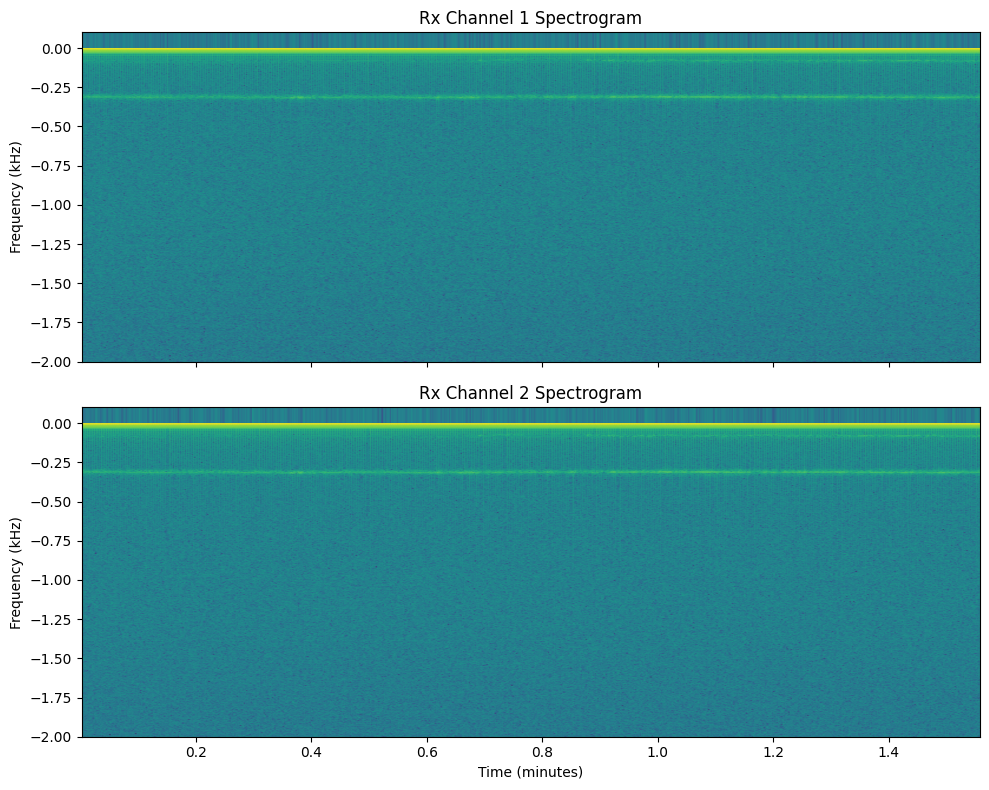

In [2]:
from scipy.signal import spectrogram

# Set the sampling frequency (Fs)
# Assuming 0.245 seconds interval between each frame and 1024 samples in each frame
Fs = 1024 / 0.245  # Hz

# Compute the spectrogram for Rx Channel 1
f1, t1, Sxx1 = spectrogram(x1.flatten(), fs=Fs, nperseg=1024, noverlap=512)

# Compute the spectrogram for Rx Channel 2
f2, t2, Sxx2 = spectrogram(x2.flatten(), fs=Fs, nperseg=1024, noverlap=512)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Rx Channel 1 spectrogram
axs[0].pcolormesh(t1 / 60, f1 / 1e3, 10 * np.log10(np.abs(Sxx1)), shading='gouraud')
axs[0].set_ylabel('Frequency (kHz)')
axs[0].set_title('Rx Channel 1 Spectrogram')
axs[0].set_ylim([-2, 0.1])  # Limit frequency range to -2 to 2 kHz

# Plot Rx Channel 2 spectrogram
axs[1].pcolormesh(t2 / 60, f2 / 1e3, 10 * np.log10(np.abs(Sxx2)), shading='gouraud')
axs[1].set_xlabel('Time (minutes)')
axs[1].set_ylabel('Frequency (kHz)')
axs[1].set_title('Rx Channel 2 Spectrogram')
axs[1].set_ylim([-2, 0.1])  # Limit frequency range to -2 to 2 kHz

plt.tight_layout()
plt.show()

/tmp/ipykernel_1921/2714859272.py:31: UserWarning: Input data is complex, switching to return_onesided=False
  f1, t1, Sxx1 = spectrogram(x1.flatten(), fs=Fs, nperseg=1024, noverlap=512)


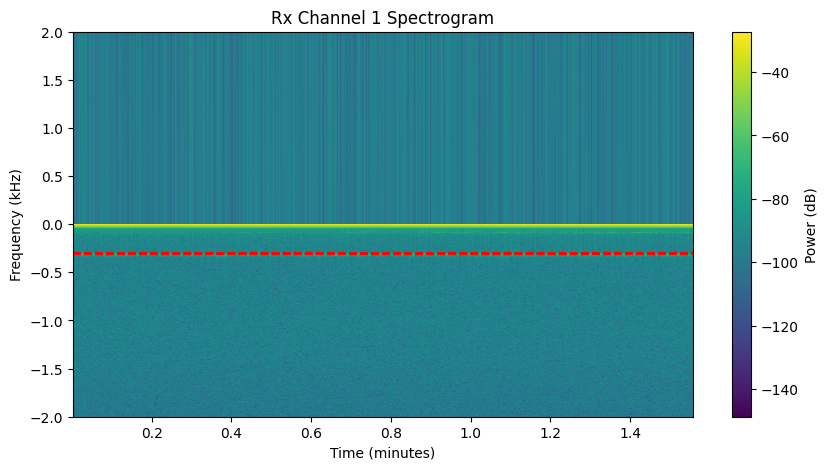

Detected CFAR peaks at frequencies (kHz): [-0.31428571 -0.31020408 -0.30612245 -0.30204082]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Define a simple CFAR function
def cfar_detector(signal, num_train, num_guard, rate_fa):
    N = len(signal)
    cfar_mask = np.zeros(N)

    for i in range(num_train + num_guard, N - num_train - num_guard):
        # Define the leading and lagging training cells
        leading_train = signal[i - num_train - num_guard : i - num_guard]
        lagging_train = signal[i + num_guard + 1 : i + num_guard + num_train + 1]

        # Calculate the noise level from the training cells
        noise_level = (np.mean(leading_train) + np.mean(lagging_train)) / 2

        # Set the CFAR threshold
        threshold = noise_level * rate_fa

        # Check if the current cell exceeds the threshold
        if signal[i] > threshold:
            cfar_mask[i] = 1

    return cfar_mask

# Assuming x1 is the combined complex signal from earlier steps
Fs = 1024 / 0.245  # Hz

# Compute the spectrogram for Rx Channel 1
f1, t1, Sxx1 = spectrogram(x1.flatten(), fs=Fs, nperseg=1024, noverlap=512)

# Compute the average power across time
avg_power1 = np.mean(np.abs(Sxx1), axis=1)

# Parameters for CFAR
num_train = 10  # Number of training cells
num_guard = 2   # Number of guard cells
rate_fa = 5     # False alarm rate multiplier (adjust as needed)

# Apply CFAR
cfar_mask = cfar_detector(avg_power1, num_train, num_guard, rate_fa)

# Plotting the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t1 / 60, f1 / 1e3, 10 * np.log10(np.abs(Sxx1)), shading='gouraud')
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency (kHz)')
plt.ylim([-2, 2])  # Limit frequency range to -2 to 2 kHz
plt.title('Rx Channel 1 Spectrogram')

# Highlight detected peaks with CFAR
detected_freqs = f1[cfar_mask == 1]
for freq in detected_freqs:
    plt.hlines(freq / 1e3, xmin=t1[0] / 60, xmax=t1[-1] / 60, color='red', linestyle='--')

plt.show()

# Print the detected frequencies in kHz
print("Detected CFAR peaks at frequencies (kHz):", detected_freqs / 1e3)


In [4]:
detected_freqs_hz = detected_freqs  # Detected beat frequencies in Hz

# Convert the beat frequencies to range (distance)
ranges = (C * detected_freqs_hz) / (2 * m_w)
print("Detected ranges (m):", abs(ranges))

Detected ranges (m): [15.13809155 14.94149295 14.74489436 14.54829577]


/tmp/ipykernel_1921/4128634491.py:10: UserWarning: Input data is complex, switching to return_onesided=False
  f1, t1, Sxx1 = spectrogram(x1_subset, fs=Fs, nperseg=1024, noverlap=512)


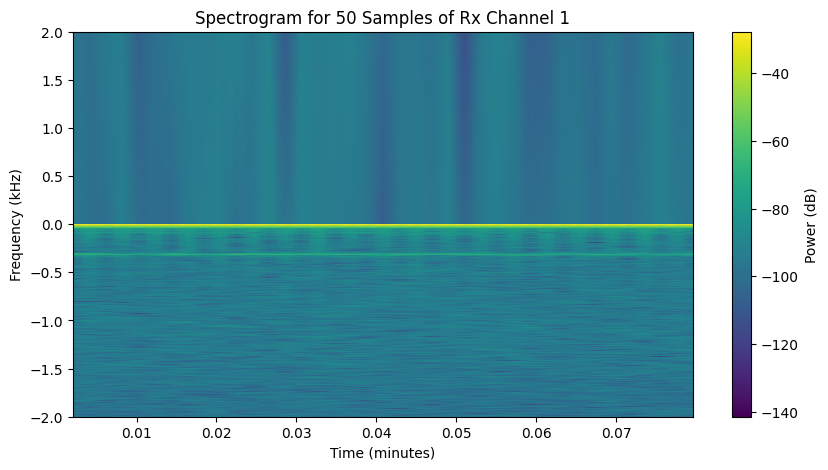

In [5]:
num_samples = 20

# Slice the data to use only the first 50 samples
x1_subset = x1[:num_samples, :].flatten()  # Flatten the sliced array

# Set the sampling frequency (Fs)
Fs = 1024 / 0.245  # Hz

# Compute the spectrogram for the subset of data
f1, t1, Sxx1 = spectrogram(x1_subset, fs=Fs, nperseg=1024, noverlap=512)

# Plotting the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t1 / 60, f1 / 1e3, 10 * np.log10(np.abs(Sxx1)), shading='gouraud')
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency (kHz)')
plt.ylim([-2, 2])  # Limit frequency range to -2 to 2 kHz
plt.title('Spectrogram for 50 Samples of Rx Channel 1')
plt.show()